# TALLER 2 - CLASIFICACIÓN DE IMÁGENES - CIENCIA DE DATOS APLICADA

* Jairo Adolfo Céspedes Plata

* Santiago Iván Pardo Morales



In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
!pip install pandas Pillow

In [ ]:
import os
import pandas as pd
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
#!git clone https://github.com/marcusklasson/GroceryStoreDataset.git /content/drive/MyDrive/GroceryStoreDataset

## CARGA DE DATOS

Como se trabajó desde Google Colab, se realizó una importación de los datos clonando el repositorio a Google Drive, se hizo fijación en los datasets classes_df, train_df, test_df y val_df

In [ ]:
dataset_dir = '/content/drive/MyDrive/GroceryStoreDataset/dataset/'
os.chdir(dataset_dir)

Carga de los nombres de las clases

In [ ]:
# Cargar el archivo de clases
classes_df = pd.read_csv('classes.csv')
classes_df.head()

,Class Name (str),Class ID (int),Coarse Class Name (str),Coarse Class ID (int),Iconic Image Path (str),Product Description Path (str)
0,Golden-Delicious,0,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Go...,/iconic-images-and-descriptions/Fruit/Apple/Go...
1,Granny-Smith,1,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Gr...,/iconic-images-and-descriptions/Fruit/Apple/Gr...
2,Pink-Lady,2,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Pi...,/iconic-images-and-descriptions/Fruit/Apple/Pi...
3,Red-Delicious,3,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Re...,/iconic-images-and-descriptions/Fruit/Apple/Re...
4,Royal-Gala,4,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Ro...,/iconic-images-and-descriptions/Fruit/Apple/Ro...


Carga de los archivos de entrenamiento, prueba y validación

In [ ]:
# Cargar el archivo de entrenamiento
train_df = pd.read_csv('train.txt', sep=',', header=None, names=['image_path', 'fine_label', 'coarse_label'])
# Cargar el archivo de test
test_df = pd.read_csv('test.txt', sep=',', header=None, names=['image_path', 'fine_label', 'coarse_label'])
# Cargar el archivo de validación
val_df = pd.read_csv('val.txt', sep=',', header=None, names=['image_path', 'fine_label', 'coarse_label'])

# Mostrar las primeras filas
train_df.head()

,image_path,fine_label,coarse_label
0,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0
1,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0
2,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0
3,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0
4,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0


Se hizo la visualización de una imágen arbitraria, para comprobar que los datos se cargaron correctamente

train/Fruit/Apple/Golden-Delicious/Golden-Delicious_001.jpg


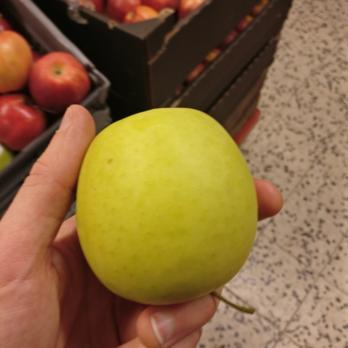

In [ ]:
# Cargar y mostrar una imagen de ejemplo
image_path = train_df.iloc[0]['image_path']
print(image_path)
image = Image.open(image_path)
image

Para facilitar los cruces, dado que las imágenes se encuentran en ID, se renombraron las columnas para facilitar el cruce entre estos datasets

In [ ]:
# Renombrar columnas en classes_df para facilitar el cruce
classes_df = classes_df.rename(columns={
    'Class ID (int)': 'fine_label',
    'Coarse Class ID (int)': 'coarse_label',
    'Class Name (str)': 'class_name',
    'Coarse Class Name (str)': 'coarse_class_name'
})
classes_df.head()

,class_name,fine_label,coarse_class_name,coarse_label,Iconic Image Path (str),Product Description Path (str)
0,Golden-Delicious,0,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Go...,/iconic-images-and-descriptions/Fruit/Apple/Go...
1,Granny-Smith,1,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Gr...,/iconic-images-and-descriptions/Fruit/Apple/Gr...
2,Pink-Lady,2,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Pi...,/iconic-images-and-descriptions/Fruit/Apple/Pi...
3,Red-Delicious,3,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Re...,/iconic-images-and-descriptions/Fruit/Apple/Re...
4,Royal-Gala,4,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Ro...,/iconic-images-and-descriptions/Fruit/Apple/Ro...


In [ ]:
# Realizar el cruce y agregar nombres de clases al train_df
train_df = train_df.merge(
    classes_df[['fine_label', 'coarse_label', 'class_name', 'coarse_class_name']],
    on=['fine_label', 'coarse_label'],
    how='left'
)

# Mostrar los primeros registros del DataFrame actualizado
train_df.head()

,image_path,fine_label,coarse_label,class_name,coarse_class_name
0,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Golden-Delicious,Apple
1,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Golden-Delicious,Apple
2,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Golden-Delicious,Apple
3,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Golden-Delicious,Apple
4,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Golden-Delicious,Apple


## 1. ENTENDIMIENTO Y PREPARACIÓN DE DATOS

In [ ]:
# Dimensiones del dataset
num_images = train_df.shape[0]
num_classes = classes_df.shape[0]

print(f"El dataset tiene {num_images} imágenes y {num_classes} clases específicas.")

El dataset tiene 2640 imágenes y 81 clases específicas.


In [ ]:
# Distribución de imágenes por clase específica
fine_label_counts = train_df['class_name'].value_counts()
print("Varias distribuciones de imágenes por clase específica:")
fine_label_counts.head(10)

Varias distribuciones de imágenes por clase específica:


,count
class_name,
Satsumas,70
Royal-Gala,65
Granny-Smith,59
Pink-Lady,59
Orange,57
Regular-Tomato,50
Red-Delicious,50
Kiwi,46
Watermelon,46


In [ ]:
# Distribución de imágenes por categoría general
coarse_label_counts = train_df['coarse_class_name'].value_counts()
print("Distribución de imágenes por categoría general:")
coarse_label_counts

Distribución de imágenes por categoría general:


,count
coarse_class_name,
Apple,278
Juice,247
Milk,182
Yoghurt,181
Melon,154
Tomato,127
Pear,116
Pepper,112
Potato,75


### Estadísticas del tamaño de las imágenes

Se obtuvo una descripción y estadísticas generales sobre las dimensiones de las imágenes

In [ ]:
# Función para obtener dimensiones de las imágenes
def get_image_dimensions(image_paths, dataset_dir):
    dimensions = []
    for image_path in image_paths:
        img = Image.open(os.path.join(dataset_dir, image_path))
        dimensions.append(img.size)  # (width, height)
    return dimensions

# Obtener dimensiones de las imágenes del dataset
train_df['dimensions'] = get_image_dimensions(train_df['image_path'], dataset_dir)

# Calcular estadísticas de dimensiones
dimension_stats = train_df['dimensions'].apply(lambda x: {'width': x[0], 'height': x[1]})
dimension_stats = pd.DataFrame(list(dimension_stats))

print("Estadísticas de dimensiones:")
print(dimension_stats.describe())

Estadísticas de dimensiones:
             width       height
count  2640.000000  2640.000000
mean    348.746970   353.536364
std       9.280256    24.734563
min     348.000000   348.000000
25%     348.000000   348.000000
50%     348.000000   348.000000
75%     348.000000   348.000000
max     464.000000   464.000000


### Distribución de formatos de imágenes

Se comprueba que el dataset tiene 2640 imágenes

In [ ]:
# Obtener formatos de las imágenes
def get_image_formats(image_paths, dataset_dir):
    formats = []
    for image_path in image_paths:
        img = Image.open(os.path.join(dataset_dir, image_path))
        formats.append(img.format)
    return formats

# Añadir formatos al DataFrame
train_df['format'] = get_image_formats(train_df['image_path'], dataset_dir)

# Calcular distribución de formatos
format_distribution = train_df['format'].value_counts()
print("Distribución de formatos de imágenes:")
print(format_distribution)

Distribución de formatos de imágenes:
format
JPEG    2640
Name: count, dtype: int64


Se hizo una estadística general sobre los colores en paleta RGB de las primeras imágenes

In [ ]:
from sklearn.cluster import KMeans

# Función para obtener el color predominante en una imagen
def get_dominant_color(image_path, dataset_dir, k=1):
    img = Image.open(os.path.join(dataset_dir, image_path))
    img = img.resize((50, 50))  # Redimensionar para optimizar el cálculo
    img_array = np.array(img).reshape(-1, 3)  # Convertir a matriz de colores
    kmeans = KMeans(n_clusters=k, random_state=0).fit(img_array)
    dominant_color = kmeans.cluster_centers_[0]
    return tuple(map(int, dominant_color))

# Obtener colores predominantes para las primeras imágenes
train_df['dominant_color'] = train_df['image_path'].apply(
    lambda x: get_dominant_color(x, dataset_dir)
)

print("Colores predominantes de las primeras imágenes:")
print(train_df[['image_path', 'dominant_color']].head())

Colores predominantes de las primeras imágenes:
                                          image_path  dominant_color
0  train/Fruit/Apple/Golden-Delicious/Golden-Deli...  (137, 104, 61)
1  train/Fruit/Apple/Golden-Delicious/Golden-Deli...  (143, 112, 47)
2  train/Fruit/Apple/Golden-Delicious/Golden-Deli...  (126, 105, 20)
3  train/Fruit/Apple/Golden-Delicious/Golden-Deli...  (140, 111, 56)
4  train/Fruit/Apple/Golden-Delicious/Golden-Deli...  (134, 110, 19)


### Creación de nuevas clases

**Bono: Realice su modelo usando el nivel detallado de tipos de productos y sus
marcas. (por ej. Manzanas Golden-Delicious, Granny-Smith, etc).**

Se realizó la creación de una nueva clase uniendo coarse_name con coarse_class_name, esto con el objetivo de realizar la clasificación teniendo en cuenta la categoría y la subcategoría del producto

In [ ]:
train_df['class_standard'] = train_df.apply(
    lambda row: row['coarse_class_name'] if row['class_name'] == row['coarse_class_name']
    else f"{row['coarse_class_name']}_{row['class_name']}",
    axis=1
)

### Selección de Productos y Categorías

Para hacer el modelo más efectivo en términos de clasificación, escogemos aquellos cuya cantidad de imágenes (teniendo en cuenta las clases principales) sea mayor a 100, posteriormente, se creará la clase con el objetivo de realizarla más detallada en términos de subcategorías

In [ ]:
# Contar imágenes por categoría general (coarse_label)
coarse_label_counts = train_df['coarse_class_name'].value_counts()

# Mostrar las categorías generales con más imágenes (Top 5)
print("Top 5 Coarse-Grained Categories con más imágenes:")
print(coarse_label_counts.head())

# Seleccionar categorías generales basadas en la cantidad de imágenes
# Aquí seleccionamos las categorías con más de un umbral arbitrario, por ejemplo, 200 imágenes.
threshold = 100
selected_coarse_labels = coarse_label_counts[coarse_label_counts > threshold].index.tolist()

print("Categorías seleccionadas (coarse-grained):")
print(selected_coarse_labels)

Top 5 Coarse-Grained Categories con más imágenes:
coarse_class_name
Apple      278
Juice      247
Milk       182
Yoghurt    181
Melon      154
Name: count, dtype: int64
Categorías seleccionadas (coarse-grained):
['Apple', 'Juice', 'Milk', 'Yoghurt', 'Melon', 'Tomato', 'Pear', 'Pepper']


In [ ]:
# Filtrar las categorías seleccionadas que también están en la columna 'class_standard'
selected_class_standard = train_df[train_df['coarse_class_name'].isin(selected_coarse_labels)]['class_standard'].unique()

# Mostrar las categorías seleccionadas dentro de 'class_standard'
print("Categorías seleccionadas dentro de class_standard:")
print(selected_class_standard)

Categorías seleccionadas dentro de class_standard:
['Apple_Golden-Delicious' 'Apple_Granny-Smith' 'Apple_Pink-Lady'
 'Apple_Red-Delicious' 'Apple_Royal-Gala' 'Melon_Cantaloupe'
 'Melon_Galia-Melon' 'Melon_Honeydew-Melon' 'Melon_Watermelon'
 'Pear_Anjou' 'Pear_Conference' 'Pear_Kaiser' 'Juice_Bravo-Apple-Juice'
 'Juice_Bravo-Orange-Juice' 'Juice_God-Morgon-Apple-Juice'
 'Juice_God-Morgon-Orange-Juice'
 'Juice_God-Morgon-Orange-Red-Grapefruit-Juice'
 'Juice_God-Morgon-Red-Grapefruit-Juice' 'Juice_Tropicana-Apple-Juice'
 'Juice_Tropicana-Golden-Grapefruit' 'Juice_Tropicana-Juice-Smooth'
 'Juice_Tropicana-Mandarin-Morning' 'Milk_Arla-Ecological-Medium-Fat-Milk'
 'Milk_Arla-Lactose-Medium-Fat-Milk' 'Milk_Arla-Medium-Fat-Milk'
 'Milk_Arla-Standard-Milk' 'Milk_Garant-Ecological-Medium-Fat-Milk'
 'Milk_Garant-Ecological-Standard-Milk'
 'Yoghurt_Arla-Mild-Vanilla-Yoghurt'
 'Yoghurt_Arla-Natural-Mild-Low-Fat-Yoghurt'
 'Yoghurt_Arla-Natural-Yoghurt' 'Yoghurt_Valio-Vanilla-Yoghurt'
 'Yoghurt_Yoggi

In [ ]:
train_df

,image_path,fine_label,coarse_label,class_name,coarse_class_name,dimensions,format,dominant_color,class_standard
0,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Golden-Delicious,Apple,"(348, 348)",JPEG,"(137, 104, 61)",Apple_Golden-Delicious
1,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Golden-Delicious,Apple,"(348, 348)",JPEG,"(143, 112, 47)",Apple_Golden-Delicious
2,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Golden-Delicious,Apple,"(348, 348)",JPEG,"(126, 105, 20)",Apple_Golden-Delicious
3,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Golden-Delicious,Apple,"(348, 348)",JPEG,"(140, 111, 56)",Apple_Golden-Delicious
4,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Golden-Delicious,Apple,"(348, 348)",JPEG,"(134, 110, 19)",Apple_Golden-Delicious
...,...,...,...,...,...,...,...,...,...
2635,train/Vegetables/Zucchini/Zucchini_026.jpg,80,42,Zucchini,Zucchini,"(348, 348)",JPEG,"(117, 103, 75)",Zucchini
2636,train/Vegetables/Zucchini/Zucchini_027.jpg,80,42,Zucchini,Zucchini,"(348, 348)",JPEG,"(106, 92, 54)",Zucchini
2637,train/Vegetables/Zucchini/Zucchini_028.jpg,80,42,Zucchini,Zucchini,"(348, 348)",JPEG,"(111, 95, 76)",Zucchini
2638,train/Vegetables/Zucchini/Zucchini_029.jpg,80,42,Zucchini,Zucchini,"(348, 348)",JPEG,"(101, 87, 53)",Zucchini


In [ ]:
# Filtrar el DataFrame por las categorías coarse_class_name
filtered_coarse_df = train_df[train_df['coarse_class_name'].isin(selected_coarse_labels)]

print(f"Cantidad de imágenes después de filtrar por categorías generales: {filtered_coarse_df.shape[0]}")

# Mostrar distribución de categorías seleccionadas
selected_coarse_distribution = filtered_coarse_df['coarse_class_name'].value_counts()
print("Distribución de imágenes en las categorías seleccionadas:")
print(selected_coarse_distribution)

Cantidad de imágenes después de filtrar por categorías generales: 1397
Distribución de imágenes en las categorías seleccionadas:
coarse_class_name
Apple      278
Juice      247
Milk       182
Yoghurt    181
Melon      154
Tomato     127
Pear       116
Pepper     112
Name: count, dtype: int64


In [ ]:
class_standard_counts = filtered_coarse_df['class_standard'].value_counts()
print("Top 5 Class Standard Categories con más imágenes:")
print(class_standard_counts)

Top 5 Class Standard Categories con más imágenes:
class_standard
Apple_Royal-Gala                                65
Apple_Pink-Lady                                 59
Apple_Granny-Smith                              59
Apple_Red-Delicious                             50
Tomato_Regular-Tomato                           50
Melon_Watermelon                                46
Apple_Golden-Delicious                          45
Pear_Conference                                 45
Tomato_Vine-Tomato                              43
Yoghurt_Arla-Natural-Yoghurt                    42
Pear_Anjou                                      41
Melon_Cantaloupe                                39
Melon_Honeydew-Melon                            36
Milk_Garant-Ecological-Medium-Fat-Milk          35
Milk_Arla-Medium-Fat-Milk                       34
Tomato_Beef-Tomato                              34
Pepper_Red-Bell-Pepper                          34
Melon_Galia-Melon                               33
Juice_Bravo-Orang

Realizar visualización de categorías generales seleccionadas

Mostrando imágenes de categorías generales seleccionadas:


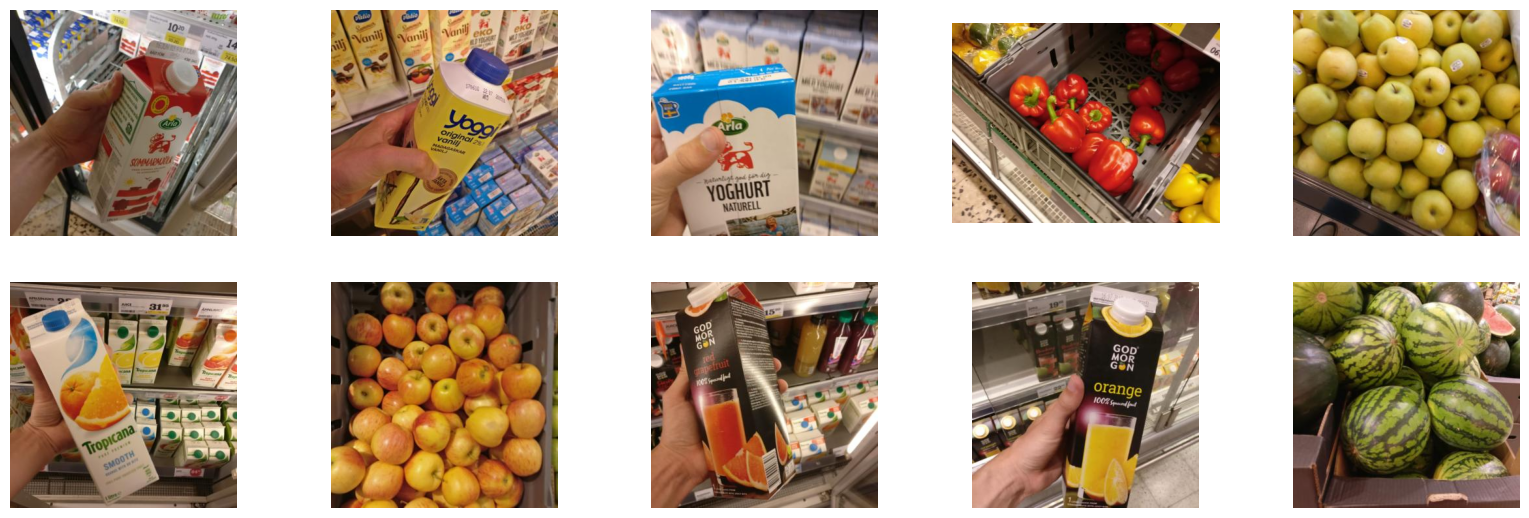

In [ ]:
# Mostrar algunas imágenes de las categorías seleccionadas
sample_images = filtered_coarse_df.sample(10)['image_path'].tolist()

def show_images(image_paths, cols=5):
    plt.figure(figsize=(20, 10))
    for i, image_path in enumerate(image_paths):
        img = Image.open(os.path.join(dataset_dir, image_path))
        plt.subplot(len(image_paths) // cols + 1, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

print("Mostrando imágenes de categorías generales seleccionadas:")
show_images(sample_images)

### Aumento de Datos

In [ ]:
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

# Definir transformaciones de aumento de datos
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ToTensor()
])

# Crear un nuevo DataFrame para almacenar rutas y etiquetas de imágenes aumentadas
augmented_data = []

def augment_and_save_images_with_labels(df, dataset_dir, output_dir, transforms, num_augmentations=1):
    """
    Aplica aumentos de datos a las imágenes y crea un nuevo DataFrame con rutas de imágenes aumentadas y etiquetas.

    Args:
    - df: DataFrame con columnas 'image_path', 'fine_label', y 'coarse_label'.
    - dataset_dir: Directorio raíz del dataset original.
    - output_dir: Directorio donde se guardarán las imágenes aumentadas.
    - transforms: Transformaciones a aplicar.
    - num_augmentations: Número de imágenes aumentadas por cada imagen original.

    Returns:
    - augmented_data: Lista con rutas y etiquetas de imágenes aumentadas.
    """
    os.makedirs(output_dir, exist_ok=True)

    for _, row in df.iterrows():
        img_path = os.path.join(dataset_dir, row['image_path'])
        original_image = Image.open(img_path)

        for i in range(num_augmentations):
            augmented_image = transforms(original_image)

            # Convertir tensor a imagen PIL
            augmented_image_pil = to_pil_image(augmented_image)

            # Crear un nuevo nombre para la imagen aumentada
            base_name = os.path.basename(row['image_path'])
            new_name = f"{os.path.splitext(base_name)[0]}_aug_{i}.jpg"
            new_path = os.path.join(output_dir, new_name)

            # Guardar la imagen aumentada
            augmented_image_pil.save(new_path)

            # Agregar al nuevo dataset con etiquetas
            augmented_data.append({
                'image_path': new_path.replace(output_dir, ''),  # Ruta relativa
                'fine_label': row['fine_label'],
                'coarse_label': row['coarse_label'],
                'class_name': row['class_name'],
                'coarse_class_name': row['coarse_class_name'],
                'class_standard': row['class_standard']
            })

# Directorio de salida para imágenes aumentadas
output_dir = '/content/augmented_images'

# Aplicar aumentos y guardar rutas y etiquetas en `augmented_data`
augment_and_save_images_with_labels(filtered_coarse_df, dataset_dir, output_dir, data_transforms, num_augmentations=3)

# Crear el nuevo DataFrame `train_augmented`
train_augmented = pd.DataFrame(augmented_data)

# Mostrar el nuevo DataFrame
print(f"Nuevo DataFrame creado con {train_augmented.shape[0]} imágenes aumentadas.")
print(train_augmented.head())

Nuevo DataFrame creado con 4191 imágenes aumentadas.
                        image_path  fine_label  coarse_label  \
0  /Golden-Delicious_001_aug_0.jpg           0             0   
1  /Golden-Delicious_001_aug_1.jpg           0             0   
2  /Golden-Delicious_001_aug_2.jpg           0             0   
3  /Golden-Delicious_002_aug_0.jpg           0             0   
4  /Golden-Delicious_002_aug_1.jpg           0             0   

         class_name coarse_class_name          class_standard  
0  Golden-Delicious             Apple  Apple_Golden-Delicious  
1  Golden-Delicious             Apple  Apple_Golden-Delicious  
2  Golden-Delicious             Apple  Apple_Golden-Delicious  
3  Golden-Delicious             Apple  Apple_Golden-Delicious  
4  Golden-Delicious             Apple  Apple_Golden-Delicious  


In [ ]:
# Actualizar la columna `image_path` para incluir la ruta completa
base_path = '/content/augmented_images'
train_augmented['image_path'] = train_augmented['image_path'].apply(lambda x: os.path.join(base_path, x.lstrip('/')))

# Verificar las rutas actualizadas
print("Primeras filas del DataFrame con rutas completas:")
print(train_augmented.head())

Primeras filas del DataFrame con rutas completas:
                                          image_path  fine_label  \
0  /content/augmented_images/Golden-Delicious_001...           0   
1  /content/augmented_images/Golden-Delicious_001...           0   
2  /content/augmented_images/Golden-Delicious_001...           0   
3  /content/augmented_images/Golden-Delicious_002...           0   
4  /content/augmented_images/Golden-Delicious_002...           0   

   coarse_label        class_name coarse_class_name          class_standard  
0             0  Golden-Delicious             Apple  Apple_Golden-Delicious  
1             0  Golden-Delicious             Apple  Apple_Golden-Delicious  
2             0  Golden-Delicious             Apple  Apple_Golden-Delicious  
3             0  Golden-Delicious             Apple  Apple_Golden-Delicious  
4             0  Golden-Delicious             Apple  Apple_Golden-Delicious  


/content/augmented_images/Golden-Delicious_001_aug_0.jpg


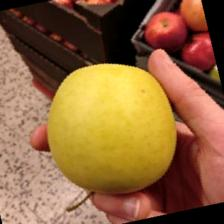

In [ ]:
# Cargar y mostrar una imagen de ejemplo
image_path_au = train_augmented.iloc[0]['image_path']
print(image_path_au)
imageau = Image.open(image_path_au)
imageau

In [ ]:
train_combined = pd.concat([filtered_coarse_df, train_augmented], ignore_index=True)
print(f"DataFrame combinado contiene {train_combined.shape[0]} imágenes.")

DataFrame combinado contiene 5588 imágenes.


## 2. ENTRENAMIENTO DEL MODELO DE MACHINE LEARNING

### Modificar el df de test y validación para que se ajuste

In [ ]:
# Realizar el cruce y agregar nombres de clases al train_df
test_df = test_df.merge(
    classes_df[['fine_label', 'coarse_label', 'class_name', 'coarse_class_name']],
    on=['fine_label', 'coarse_label'],
    how='left'
)

In [ ]:
test_df['class_standard'] = test_df.apply(
    lambda row: row['coarse_class_name'] if row['class_name'] == row['coarse_class_name']
    else f"{row['coarse_class_name']}_{row['class_name']}",
    axis=1
)

In [ ]:
# Mostrar los primeros registros del DataFrame actualizado
test_df.head()

,image_path,fine_label,coarse_label,class_name,coarse_class_name,class_standard
0,test/Fruit/Apple/Golden-Delicious/Golden-Delic...,0,0,Golden-Delicious,Apple,Apple_Golden-Delicious
1,test/Fruit/Apple/Golden-Delicious/Golden-Delic...,0,0,Golden-Delicious,Apple,Apple_Golden-Delicious
2,test/Fruit/Apple/Golden-Delicious/Golden-Delic...,0,0,Golden-Delicious,Apple,Apple_Golden-Delicious
3,test/Fruit/Apple/Golden-Delicious/Golden-Delic...,0,0,Golden-Delicious,Apple,Apple_Golden-Delicious
4,test/Fruit/Apple/Golden-Delicious/Golden-Delic...,0,0,Golden-Delicious,Apple,Apple_Golden-Delicious


In [ ]:
# Realizar el cruce y agregar nombres de clases al train_df
val_df = val_df.merge(
    classes_df[['fine_label', 'coarse_label', 'class_name', 'coarse_class_name']],
    on=['fine_label', 'coarse_label'],
    how='left'
)

In [ ]:
val_df['class_standard'] = val_df.apply(
    lambda row: row['coarse_class_name'] if row['class_name'] == row['coarse_class_name']
    else f"{row['coarse_class_name']}_{row['class_name']}",
    axis=1
)

In [ ]:
# Mostrar los primeros registros del DataFrame actualizado
val_df.head()

,image_path,fine_label,coarse_label,class_name,coarse_class_name,class_standard
0,val/Fruit/Apple/Golden-Delicious/Golden-Delici...,0,0,Golden-Delicious,Apple,Apple_Golden-Delicious
1,val/Fruit/Apple/Golden-Delicious/Golden-Delici...,0,0,Golden-Delicious,Apple,Apple_Golden-Delicious
2,val/Fruit/Apple/Golden-Delicious/Golden-Delici...,0,0,Golden-Delicious,Apple,Apple_Golden-Delicious
3,val/Fruit/Apple/Golden-Delicious/Golden-Delici...,0,0,Golden-Delicious,Apple,Apple_Golden-Delicious
4,val/Fruit/Apple/Golden-Delicious/Golden-Delici...,0,0,Golden-Delicious,Apple,Apple_Golden-Delicious


In [ ]:
# Filtrar el DataFrame por las categorías coarse_class_name
filtered_coarse_test_df = test_df[test_df['coarse_class_name'].isin(selected_coarse_labels)]

print(f"Cantidad de imágenes después de filtrar por categorías generales: {filtered_coarse_test_df.shape[0]}")

# Mostrar distribución de categorías seleccionadas
selected_coarse_distribution_test_df = filtered_coarse_test_df['coarse_class_name'].value_counts()
print("Distribución de imágenes en las categorías seleccionadas:")
print(selected_coarse_distribution_test_df)

Cantidad de imágenes después de filtrar por categorías generales: 1302
Distribución de imágenes en las categorías seleccionadas:
coarse_class_name
Apple      276
Juice      219
Yoghurt    172
Milk       164
Melon      153
Pepper     110
Pear       108
Tomato     100
Name: count, dtype: int64


In [ ]:
selected_class_standard_test_df = filtered_coarse_test_df['class_standard'].value_counts()
print("Distribución de imágenes en las subcategorías seleccionadas:")
print(selected_class_standard_test_df)

Distribución de imágenes en las subcategorías seleccionadas:
class_standard
Apple_Royal-Gala                                64
Apple_Pink-Lady                                 59
Apple_Granny-Smith                              58
Apple_Red-Delicious                             50
Tomato_Regular-Tomato                           47
Melon_Watermelon                                46
Apple_Golden-Delicious                          45
Pear_Conference                                 44
Tomato_Vine-Tomato                              43
Yoghurt_Arla-Natural-Yoghurt                    41
Melon_Cantaloupe                                39
Melon_Honeydew-Melon                            36
Pear_Anjou                                      35
Milk_Garant-Ecological-Medium-Fat-Milk          35
Milk_Arla-Medium-Fat-Milk                       34
Pepper_Red-Bell-Pepper                          33
Melon_Galia-Melon                               32
Yoghurt_Yoggi-Strawberry-Yoghurt                32
Juice_

In [ ]:
# Filtrar el DataFrame por las categorías coarse_class_name
filtered_coarse_val_df = val_df[val_df['coarse_class_name'].isin(selected_coarse_labels)]

print(f"Cantidad de imágenes después de filtrar por categorías generales: {filtered_coarse_val_df.shape[0]}")

# Mostrar distribución de categorías seleccionadas
selected_coarse_distribution_val_df = filtered_coarse_val_df['coarse_class_name'].value_counts()
print("Distribución de imágenes en las categorías seleccionadas:")
print(selected_coarse_distribution_val_df)

Cantidad de imágenes después de filtrar por categorías generales: 145
Distribución de imágenes en las categorías seleccionadas:
coarse_class_name
Juice      29
Milk       26
Apple      22
Melon      20
Yoghurt    20
Pepper     15
Tomato      8
Pear        5
Name: count, dtype: int64


In [ ]:
filtered_coarse_val_df

,image_path,fine_label,coarse_label,class_name,coarse_class_name,class_standard
0,val/Fruit/Apple/Golden-Delicious/Golden-Delici...,0,0,Golden-Delicious,Apple,Apple_Golden-Delicious
1,val/Fruit/Apple/Golden-Delicious/Golden-Delici...,0,0,Golden-Delicious,Apple,Apple_Golden-Delicious
2,val/Fruit/Apple/Golden-Delicious/Golden-Delici...,0,0,Golden-Delicious,Apple,Apple_Golden-Delicious
3,val/Fruit/Apple/Golden-Delicious/Golden-Delici...,0,0,Golden-Delicious,Apple,Apple_Golden-Delicious
4,val/Fruit/Apple/Golden-Delicious/Golden-Delici...,0,0,Golden-Delicious,Apple,Apple_Golden-Delicious
...,...,...,...,...,...,...
286,val/Vegetables/Tomato/Vine-Tomato/Vine-Tomato_...,79,41,Vine-Tomato,Tomato,Tomato_Vine-Tomato
287,val/Vegetables/Tomato/Vine-Tomato/Vine-Tomato_...,79,41,Vine-Tomato,Tomato,Tomato_Vine-Tomato
288,val/Vegetables/Tomato/Vine-Tomato/Vine-Tomato_...,79,41,Vine-Tomato,Tomato,Tomato_Vine-Tomato
289,val/Vegetables/Tomato/Vine-Tomato/Vine-Tomato_...,79,41,Vine-Tomato,Tomato,Tomato_Vine-Tomato


In [ ]:
selected_class_standard_val_df = filtered_coarse_val_df['class_standard'].value_counts()
print("Distribución de imágenes en las subcategorías seleccionadas:")
print(selected_class_standard_val_df)

Distribución de imágenes en las subcategorías seleccionadas:
class_standard
Apple_Golden-Delicious                          6
Melon_Cantaloupe                                6
Milk_Garant-Ecological-Standard-Milk            6
Milk_Garant-Ecological-Medium-Fat-Milk          6
Juice_God-Morgon-Orange-Red-Grapefruit-Juice    6
Apple_Granny-Smith                              6
Milk_Arla-Ecological-Medium-Fat-Milk            5
Pepper_Yellow-Bell-Pepper                       5
Pepper_Red-Bell-Pepper                          5
Pepper_Orange-Bell-Pepper                       5
Yoghurt_Yoggi-Vanilla-Yoghurt                   5
Yoghurt_Yoggi-Strawberry-Yoghurt                5
Yoghurt_Valio-Vanilla-Yoghurt                   5
Yoghurt_Arla-Mild-Vanilla-Yoghurt               5
Milk_Arla-Standard-Milk                         5
Tomato_Vine-Tomato                              5
Juice_God-Morgon-Orange-Juice                   5
Juice_God-Morgon-Apple-Juice                    5
Juice_Bravo-Orange-Juice

### Vectorización de imágenes

Teniendo la imágen se realizó la conversión de la imágen en un vector de 1 dimensión, es importante mencionar que no todas las imágenes tienen el mismo tamaño, sin embargo, todas se estandarizaron a un tamaño de 64 x 64

In [ ]:
# Función para cargar y preprocesar imágenes
def load_and_preprocess_images(df, target_col, img_size=(64, 64)):
    X, y = [], []
    for _, row in df.iterrows():
        img_path = row['image_path']
        label = row[target_col]
        try:
            # Abrir y redimensionar la imagen
            img = Image.open(img_path).resize(img_size)
            img_array = np.array(img).flatten()  # Convertir a vector 1D
            X.append(img_array)
            y.append(label)
        except Exception as e:
            print(f"Error al procesar la imagen {img_path}: {e}")
    return np.array(X), np.array(y)

In [ ]:
# Cargar datos y etiquetas
X, y = load_and_preprocess_images(train_combined, target_col='class_standard', img_size=(64, 64))

In [ ]:
# Cargar datos y etiquetas
X_test, y_test = load_and_preprocess_images(filtered_coarse_test_df, target_col='class_standard', img_size=(64, 64))

In [ ]:
# Cargar datos y etiquetas
X_val, y_val = load_and_preprocess_images(filtered_coarse_val_df, target_col='class_standard', img_size=(64, 64))

Se comprueba que se realizó la vectorización los conjuntos de entrenamiento, validación y prueba

In [ ]:
X

array([[ 17,   9,   9, ..., 159, 131, 111],
       [142,  25,  38, ..., 160, 126,  28],
       [ 85,  60,   4, ..., 134, 103,  76],
       ...,
       [120,   5,   1, ...,  67,  39,  26],
       [  5,   3,   2, ...,   2,   4,   2],
       [  0,   7,   5, ..., 108,  16,  50]], dtype=uint8)

In [ ]:
X_test

array([[153, 132,  19, ..., 197, 169,  58],
       [130,  38,  26, ...,  74,  69,  62],
       [115, 107,  37, ..., 183, 159,   5],
       ...,
       [ 91,  36,  26, ...,  57,  27,  25],
       [ 33,  35,  24, ..., 102,  94,  79],
       [147, 137, 125, ..., 170, 117, 114]], dtype=uint8)

In [ ]:
X_val

array([[111, 120,  66, ...,  49,  48,  51],
       [ 47,  48,  41, ..., 130, 115,  28],
       [ 42,  29,  21, ...,  85,  72,   8],
       ...,
       [ 84,  79,  74, ..., 151, 158, 126],
       [228,  68,  44, ...,  80,  83,  50],
       [160, 131,  90, ...,  53,  49,  46]], dtype=uint8)

Se comprueba la estructura y las clases a usar

In [ ]:
np.unique(y)

array(['Apple_Golden-Delicious', 'Apple_Granny-Smith', 'Apple_Pink-Lady',
       'Apple_Red-Delicious', 'Apple_Royal-Gala',
       'Juice_Bravo-Apple-Juice', 'Juice_Bravo-Orange-Juice',
       'Juice_God-Morgon-Apple-Juice', 'Juice_God-Morgon-Orange-Juice',
       'Juice_God-Morgon-Orange-Red-Grapefruit-Juice',
       'Juice_God-Morgon-Red-Grapefruit-Juice',
       'Juice_Tropicana-Apple-Juice', 'Juice_Tropicana-Golden-Grapefruit',
       'Juice_Tropicana-Juice-Smooth', 'Juice_Tropicana-Mandarin-Morning',
       'Melon_Cantaloupe', 'Melon_Galia-Melon', 'Melon_Honeydew-Melon',
       'Melon_Watermelon', 'Milk_Arla-Ecological-Medium-Fat-Milk',
       'Milk_Arla-Lactose-Medium-Fat-Milk', 'Milk_Arla-Medium-Fat-Milk',
       'Milk_Arla-Standard-Milk',
       'Milk_Garant-Ecological-Medium-Fat-Milk',
       'Milk_Garant-Ecological-Standard-Milk', 'Pear_Anjou',
       'Pear_Conference', 'Pear_Kaiser', 'Pepper_Green-Bell-Pepper',
       'Pepper_Orange-Bell-Pepper', 'Pepper_Red-Bell-Pepper',
  

In [ ]:
np.unique(y).shape

(41,)

Se utilizarán 41 clases en total para la evaluación del modelo

## ENTRENAMIENTO DE MODELOS DE MACHINE LEARNING

### Modelo 1. Random Forest

Random Forest es un modelo de Machine Learning basado en un conjunto de árboles de decisión que combina múltiples árboles entrenados en subconjuntos aleatorios de los datos para mejorar la precisión y reducir el sobreajuste. En clasificación de imágenes, puede ser útil cuando las imágenes se transforman previamente en características numéricas, como histogramas o descriptores. Es robusto ante ruido, fácil de configurar y más interpretable que modelos complejos, aunque es menos eficiente que redes neuronales profundas si se trabaja con imágenes crudas o datasets grandes

En primer lugar, se realizó un modelo con parámetros arbitrarios para familiarizarse con los hiperparámetros del modelo

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Crear y entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Evaluar el modelo
y_pred_rf = rf_model.predict(X_test)
print("Resultados del modelo Random Forest:")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")

Resultados del modelo Random Forest:
                                              precision    recall  f1-score   support

                      Apple_Golden-Delicious       0.18      0.22      0.20        45
                          Apple_Granny-Smith       0.29      0.52      0.37        58
                             Apple_Pink-Lady       0.20      0.27      0.23        59
                         Apple_Red-Delicious       0.44      0.36      0.40        50
                            Apple_Royal-Gala       0.16      0.30      0.21        64
                     Juice_Bravo-Apple-Juice       0.07      0.04      0.05        23
                    Juice_Bravo-Orange-Juice       0.32      0.32      0.32        31
                Juice_God-Morgon-Apple-Juice       0.30      0.16      0.21        19
               Juice_God-Morgon-Orange-Juice       0.33      0.32      0.33        22
Juice_God-Morgon-Orange-Red-Grapefruit-Juice       0.00      0.00      0.00        19
       Juice_God

Vemos que el resultado de la métrica accuracy no es muy bueno, por lo que se realizará un Grid Search para intentar mejorar las métricas a través de la selección de hiperparámetros, se escogieron el número de clasificadores base y la profundidad máxima del árbol. El grid search fue implementado de una forma muy básica debido al costo computacional que trae el realizar el proceso para encontrar los mejores hiperparámetros, por lo que se trató de probar una cantidad razonable.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Definir el rango de hiperparámetros para Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],            # Número de árboles
    'max_depth': [10, 20, None],              # Profundidad máxima
}

# Crear el modelo base de Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Configurar Grid Search
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,                 # Validación cruzada con 3 particiones
    verbose=2,            # Mostrar el progreso
    n_jobs=-1             # Usar todos los núcleos disponibles
)

# Ejecutar Grid Search
grid_search.fit(X, y)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evaluar el modelo con los mejores hiperparámetros
best_rf_model = grid_search.best_estimator_
y_pred_rf_best = best_rf_model.predict(X_test)

print("Resultados del modelo Random Forest optimizado:")
print(classification_report(y_test, y_pred_rf_best))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_best):.2f}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Mejores hiperparámetros encontrados:
{'max_depth': None, 'n_estimators': 150}
Resultados del modelo Random Forest optimizado:
                                              precision    recall  f1-score   support

                      Apple_Golden-Delicious       0.20      0.22      0.21        45
                          Apple_Granny-Smith       0.34      0.66      0.45        58
                             Apple_Pink-Lady       0.25      0.37      0.30        59
                         Apple_Red-Delicious       0.50      0.36      0.42        50
                            Apple_Royal-Gala       0.18      0.34      0.24        64
                     Juice_Bravo-Apple-Juice       0.06      0.04      0.05        23
                    Juice_Bravo-Orange-Juice       0.36      0.32      0.34        31
                Juice_God-Morgon-Apple-Juice       0.00      0.00      0.00        19
               Juice_God-Morgon-Orange-

Se aplican las métricas de calidad restantes sobre los datos de prueba (Precision, Recall, Test, Área bajo la curva)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc

print("Precision:")
print("- Test:", precision_score(y_test, y_pred_rf, average='weighted'))
print("\nRecall:")
print("- Test:", recall_score(y_test, y_pred_rf, average='weighted'))
print("\nF1:")
print("- Test:", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nROC AUC:")
print("- Test:", roc_auc_score(y_test, best_rf_model.predict_proba(X_test), multi_class='ovr'))

Precision:
- Test: 0.2541107087790449

Recall:
- Test: 0.261136712749616

F1:
- Test: 0.24073580001181574

ROC AUC:
- Test: 0.8794135408855406


### Modelo 2. Regresión Logística

La regresión logística es un modelo estadístico ampliamente utilizado para clasificación multiclase, que predice probabilidades aplicando una función sigmoide. Es particularmente útil cuando las imágenes se han transformado en características numéricas, como histogramas de colores o descriptores HOG, permitiendo una clasificación eficiente incluso en conjuntos de datos extensos. Su facilidad de interpretación y capacidad para manejar relaciones lineales la hacen adecuada para tareas de clasificación de imágenes con características bien definidas y separables.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Crear el modelo de Regresión Logística
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Entrenar el modelo
log_reg.fit(X, y)

# Realizar predicciones
y_pred_lr = log_reg.predict(X_test)
print("Resultados del modelo de Regresión Logística:")
print(classification_report(y_test, y_pred_lr))
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")

Resultados del modelo de Regresión Logística:
                                              precision    recall  f1-score   support

                      Apple_Golden-Delicious       0.24      0.18      0.20        45
                          Apple_Granny-Smith       0.23      0.28      0.25        58
                             Apple_Pink-Lady       0.17      0.20      0.18        59
                         Apple_Red-Delicious       0.31      0.24      0.27        50
                            Apple_Royal-Gala       0.12      0.16      0.14        64
                     Juice_Bravo-Apple-Juice       0.27      0.13      0.18        23
                    Juice_Bravo-Orange-Juice       0.23      0.23      0.23        31
                Juice_God-Morgon-Apple-Juice       0.25      0.11      0.15        19
               Juice_God-Morgon-Orange-Juice       0.33      0.41      0.37        22
Juice_God-Morgon-Orange-Red-Grapefruit-Juice       0.17      0.05      0.08        19
       

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Definir el rango de hiperparámetros para Grid Search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularización inversa
    'penalty': [None , 'l2'],       # Tipo de regularización
}

# Crear el modelo base de regresión logística
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)

# Configurar Grid Search
grid_search = GridSearchCV(
    estimator=log_reg_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,                 # Validación cruzada con 3 particiones
    verbose=2,            # Mostrar el progreso
    n_jobs=-1             # Usar todos los núcleos disponibles
)

# Ejecutar Grid Search
grid_search.fit(X, y)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evaluar el modelo con los mejores hiperparámetros
best_log_reg_model = grid_search.best_estimator_
y_pred_log_reg_best = best_log_reg_model.predict(X_test)

print("Resultados del modelo de Regresión Logística optimizado:")
print(classification_report(y_test, y_pred_log_reg_best))
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg_best):.2f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparámetros encontrados:
{'C': 0.1, 'penalty': 'l2'}
Resultados del modelo de Regresión Logística optimizado:
                                              precision    recall  f1-score   support

                      Apple_Golden-Delicious       0.18      0.16      0.17        45
                          Apple_Granny-Smith       0.23      0.29      0.26        58
                             Apple_Pink-Lady       0.16      0.19      0.17        59
                         Apple_Red-Delicious       0.33      0.24      0.28        50
                            Apple_Royal-Gala       0.13      0.16      0.14        64
                     Juice_Bravo-Apple-Juice       0.50      0.13      0.21        23
                    Juice_Bravo-Orange-Juice       0.24      0.26      0.25        31
                Juice_God-Morgon-Apple-Juice       0.21      0.16      0.18        19
               Juice_God-Morgon-Orange-Jui

Se aplican las métricas de calidad restantes sobre los datos de prueba (Precision, Recall, Test, Área bajo la curva)

In [ ]:
print("Precision:")
print("- Test:", precision_score(y_test, y_pred_log_reg_best, average='weighted'))
print("\nRecall:")
print("- Test:", recall_score(y_test, y_pred_log_reg_best, average='weighted'))
print("\nF1:")
print("- Test:", f1_score(y_test, y_pred_log_reg_best, average='weighted'))
print("\nROC AUC:")
print("- Test:", roc_auc_score(y_test, best_log_reg_model.predict_proba(X_test), multi_class='ovr'))

Precision:
- Test: 0.2371315257197291

Recall:
- Test: 0.2196620583717358

F1:
- Test: 0.2208405252561022

ROC AUC:
- Test: 0.8525543371320772


### 3. ANÁLISIS DE LOS RESULTADOS DEL MODELO

Basado en los resultados de los grid search de ambos modelos, obtenemos que el mejor optimizado es el clasificador de Random Forest con 150 clasificadores base (árboles)

In [ ]:
y_pred_val = best_rf_model.predict(X_val)

Se hace el cálculo de métricas de calidad para el clasificador de Random Forest en los datos de validación

In [ ]:
print(classification_report(y_val, y_pred_val,zero_division=1))

                                              precision    recall  f1-score   support

                      Apple_Golden-Delicious       0.67      0.33      0.44         6
                          Apple_Granny-Smith       0.27      0.50      0.35         6
                             Apple_Pink-Lady       0.22      0.40      0.29         5
                         Apple_Red-Delicious       0.00      1.00      0.00         0
                            Apple_Royal-Gala       0.08      0.20      0.12         5
                     Juice_Bravo-Apple-Juice       0.00      0.00      0.00         4
                    Juice_Bravo-Orange-Juice       0.33      0.20      0.25         5
                Juice_God-Morgon-Apple-Juice       0.00      0.00      0.00         5
               Juice_God-Morgon-Orange-Juice       0.50      0.20      0.29         5
Juice_God-Morgon-Orange-Red-Grapefruit-Juice       1.00      0.00      0.00         6
       Juice_God-Morgon-Red-Grapefruit-Juice       0.

In [ ]:
print('Accuracy:')
print('- Validation:' ,accuracy_score(y_val, y_pred_val))
print("\nPrecision:")
print("- Validation:", precision_score(y_val, y_pred_val, average='weighted',zero_division=1))
print("\nRecall:")
print("- Validation:", recall_score(y_val, y_pred_val, average='weighted',zero_division=1))
print("\nF1:")
print("- Validation:", f1_score(y_val, y_pred_val, average='weighted',zero_division=1))


Accuracy:
- Validation: 0.15862068965517243

Precision:
- Validation: 0.3027494153356222

Recall:
- Validation: 0.15862068965517243

F1:
- Validation: 0.14387703799468507


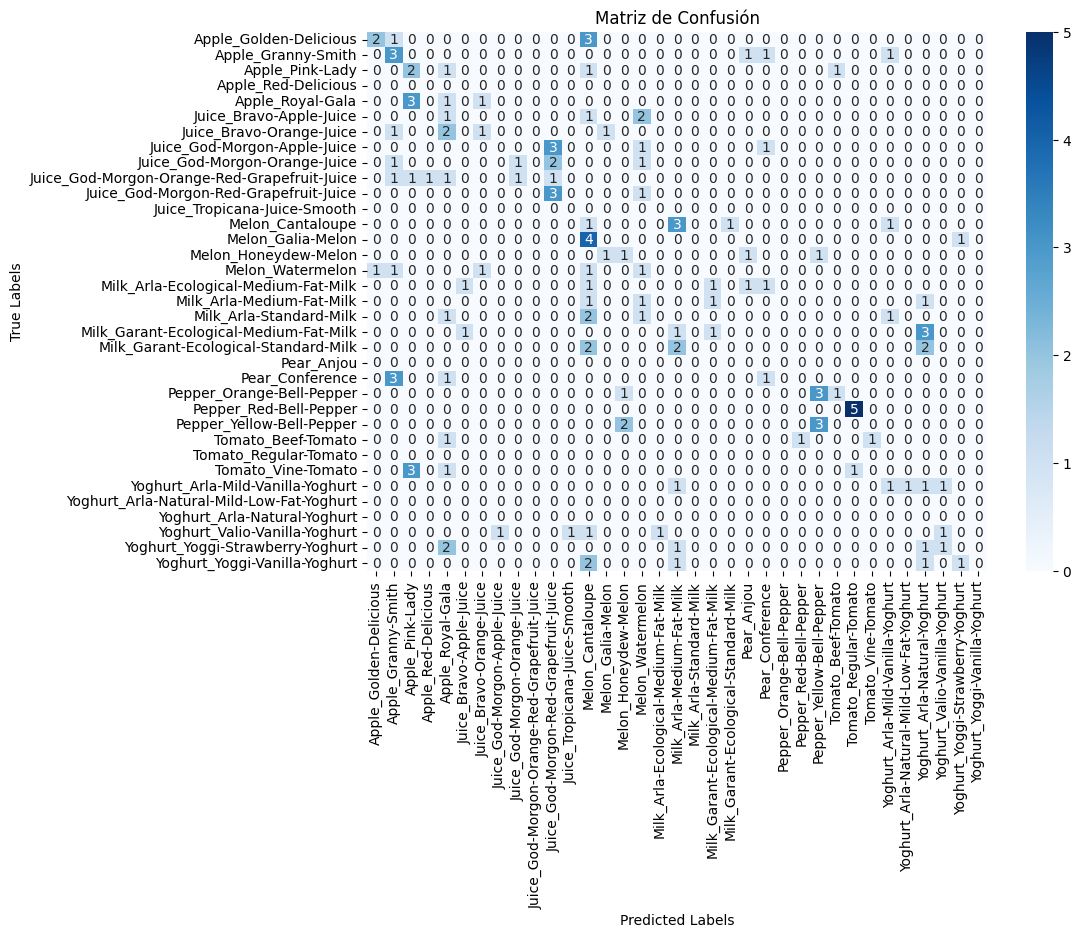

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_pred_val)

class_labels = sorted(set(y_val).union(set(y_pred_val)))

# Crear un heatmap con seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Matriz de Confusión")
plt.show()


Basado en los resultados en las métricas de calidad del modelo, se puede decir lo siguiente

* Con un valor de 15.86% de Accuracy, se indica que el desempeño del modelo refleja una capacidad muy limitada para generalizar y clasificar correctamente los productos del dataset, probablemente debido a la poca cantidad de elementos por clase en el entrenamiento y el desbalance entre clases.

* De igual forma, con un 30.27% de Precision, se indica que el modelo es moderadamente efectivo para generalizar y clasificar correctamente las imágenes en el dataset. No obstante, aún existe un margen significativo de mejora para reducir los falsos positivos y aumentar la confianza en las predicciones.

* Con un recall de 15.86%, se refleja que el modelo sólo está capturando una fracción de los casos positivos reales, lo que significa que muchos productos están siendo clasificados ya sea de forma incorrecta o completamente ignorados.

* Por último, con un 14.39% de F1-Score, indica que el modelo no está logrando un desempeño global bueno ya que debido al desequilibrio entre la precision y el recall, no identifica correctamente las clases.

A pesar de que el desempeño del modelo no es muy bueno, cabe resaltar estas características del modelo:

* Se utiliza el modelo de Random Forest, el cual es robusto frente al ruido de datos y desequilibrios de clase, lo que se convierte en una buena elección inicial para trabajar con datos complejos como imágenes de productos muy diferentes.

* La empresa realizó una buena labor con el etiquetado, y esta disponibilidad de etiquetas facilita al modelo aprender patrones y mejorar su capacidad de clasificación, con una oportunidad de mejora respecto a tener suficientes ejemplos representativos en cada clase.

Por último, con respecto a las oportunidades de mejora, se tiene lo siguiente:

* Mejorar el etiquetado, como se había mencionado anteriormente, para mejorar el desempeño de los modelos y aumentando su capacidad de generalización.

* Disminuir el nivel de clasificación, en términos de agrupación, se podrían hacer grupos con una mayor cantidad de imágenes y así mejorar significativamente el desempeño de los modelos.

* Utilizar otros modelos como las redes neuronales convolucionales que están diseñadas para aprovechar relaciones espaciales en imágenes y suelen tener mejor desempeño en la tarea de clasificación visual

## 4. GENERACIÓN DE VALOR

### Costos de Tiempo Asociados al Registro de Productos



Para calcular el costo de tiempo de productos se tienen los siguiente datos y supuestos

* Número de clientes diarios: 500 clientes al día

* Promedio de productos por cliente: 20 productos

* Tiempo de registro manual por producto: 2 segundos

* Días laborales al año: 260 días (Ministerio de Trabajo de Colombia, 2024)

* Salario mínimo mensual en Colombia (2024): Aproximadamente $1,160,000 COP. (Ministerio de Trabajo de Colombia, 2024)

* Horas laborales al mes (40 horas/semana * 4 semanas). (Ministerio de Trabajo de Colombia, 2024)

Cálculos

* Salario promedio por hora de un cajero: \begin{equation} \frac{1,160,000 \text{ COP}}{240 \text{ horas}} \approx 4,833 \text{ COP/hora} \end{equation}

* Total de productos registrados diariamente: \begin{equation} 500 \text{ clientes/día} \times 20 \text{ productos/cliente} = 10,000 \text{ productos/día} \end{equation}

* Tiempo total diario invertido en el registro manual: \begin{equation} 10,000 \text{ productos} \times 2 \text{ segundos/producto} = 20,000 \text{ segundos/día} \end{equation}

* Conversión de segundos a horas: \begin{equation} \frac{20,000 \text{ segundos}}{3,600 \text{ segundos/hora}} \approx 5.56 \text{ horas/día} \end{equation}

* Costo laboral asociado al tiempo de registro manual: \begin{equation} 5.56 \text{ horas/día} \times 4,833 \text{ COP/hora} \approx 26,800 \text{ COP/día} \end{equation}

* Costo anual: \begin{equation} 26,800 \text{ COP/día} \times 260 \text{ días} = 6,968,000 \text{ COP/año} \end{equation}







Haciendo este cálculo, con la automatización del sistema de registro de productos se ahorrarían aproximadamente $6968000 COP/año

### Ahorro de tiempo del modelo

Tener en cuenta que la precisión del modelo es del 30%

* Productos correctamente identificados por el modelo: \begin{equation} 10,000 \times 30% = 3,000
\text{ productos/día} \end{equation}

* Tiempo total diario invertido con el modelo: \begin{equation} 10,000 \text{ productos} \times 0.5 \text{ segundos/producto} = 5,000 \text{ segundos/día} \end{equation}

* Conversión de segundos a horas: \begin{equation} \frac{5,000 \text{ segundos}}{3,600 \text{ segundos/hora}} \approx 1.39 \text{ horas/día} \end{equation}

* Costo laboral asociado al tiempo con el modelo: \begin{equation} 1.39 \text{ horas/día} \times 4,833 \text{ COP/hora} \approx 6,700 \text{ COP/día} \end{equation}

* Costo anual: \begin{equation} 6,700 \text{ COP/día} \times 260 \text{ días} = 1,742,000 \text{ COP/año} \end{equation}

* Ahorro diario en tiempo laboral: \begin{equation} 26,800 \text{ COP/día} - 6,700 \text{ COP/día} = 20,100 \text{ COP/día} \end{equation}

* Ahorro anual: \begin{equation} 20,100 \times 260 = 5,226,000 \text{ COP/año} \end{equation}





Por lo que un usuario se ahorraría $5226000 COP al año asumiendo el gasto de tiempo del modelo

### Costo asociado a los errores del modelo

* Número de errores diarios: \begin{equation} 10,000 \text{ productos} \times 70% = 7,000
\text{ errores/día} \end{equation}

* Costo diario por errores: \begin{equation} 7,000 \text{ errores} \times 1,000 \text{ COP/error} = 7,000,000 \text{ COP/día} \end{equation}

* Costo anual: \begin{equation} 7,000,000 \text{ COP/día} \times 260 \text{ días} = 1,820,000,000 \text{ COP/año} \end{equation}

### Ahorro Real por Predicción Acertada

* Ahorro diario por predicciones acertadas: \begin{equation} 3,000 \times 3,000 \text{ COP} = 9,000,000 \text{ COP/día} \end{equation}

* Ahorro anual: \begin{equation} 9,000,000 \times 260 = 2,340,000,000 \text{ COP/año} \end{equation}

### ROI tomando en cuenta costos de desarrollo y despliegue de su modelo

Costo de desarrollo del modelo:

* Salarios de científicos de datos y desarrolladores: Supongamos un equipo de 5 profesionales con un salario promedio de 5,000,000 COP/mes cada uno.
\begin{equation} 5 \text{ profesionales} \times 5,000,000 \text{ COP/mes} \times 12 \text{ meses} = 300,000,000 \text{ COP/año} \end{equation}
* Infraestructura y herramientas: Incluye computadoras, software de análisis, licencias, etc. Supongamos un costo único de 500,000,000 COP. \begin{equation} 500,000,000 \text{ COP} \end{equation}
* Adquisición y preparación de datos: Costos relacionados con la recopilación, limpieza y preparación de datos. Supongamos 200,000,000 COP. \begin{equation} 200,000,000 \text{ COP} \end{equation}
* Total costo de desarrollo: \begin{equation} 300,000,000 \text{ COP/año} + 500,000,000 \text{ COP} + 200,000,000 \text{ COP} = 1,000,000,000 \text{ COP} \end{equation}

Costo de despliegue y mantenimiento anual:

* Servidores y servicios en la nube: Supongamos 100,000,000 COP/año. \begin{equation} 100,000,000 \text{ COP/año} \end{equation}
* Actualizaciones y soporte técnico: Supongamos 260,000,000 COP/año. \begin{equation} 260,000,000 \text{ COP/año} \end{equation}
* Total costo de despliegue y mantenimiento: \begin{equation} 100,000,000 \text{ COP/año} + 260,000,000 \text{ COP/año} = 360,000,000 \text{ COP/año} \end{equation}
* Amortización del costo de desarrollo: Suponiendo una vida útil del modelo de 5 años. \begin{equation} \frac{1,000,000,000 \text{ COP}}{5} = 200,000,000 \text{ COP/año} \end{equation}

Costo total anual: \begin{equation} 200,000,000 \text{ COP/año} + 360,000,000 \text{ COP/año} = 560,000,000 \text{ COP/año} \end{equation}

Cálculos del ROI:

* Ahorro anual total: \begin{equation} 5,226,000 \text{ COP} + 2,340,000,000 \text{ COP} - 1,820,000,000 \text{ COP} = 525,226,000 \text{ COP/año} \end{equation}

* Ahorro neto anual antes de costos de inversión: \begin{equation} 525,226,000 \text{ COP} \end{equation}

* Ahorro neto anual después de costos: \begin{equation} 525,226,000 \text{ COP} - 560,000,000 \text{ COP} = -34,774,000 \text{ COP/año} \end{equation}

* Costo total de inversión: \begin{equation} 1,000,000,000 \text{ COP} + (360,000,000 \text{ COP/año} \times 5 \text{ años}) = 1,000,000,000 \text{ COP} + 1,800,000,000 \text{ COP} = 2,800,000,000 \text{ COP} \end{equation}

* Cálculo del ROI: \begin{equation} \text{ROI} = \left(\frac{-34,774,000\text{ COP}}{2,800,000,000 \text{ COP}} \right) \times 100 \approx -1.24%
\end{equation}

Punto de equilibrio (Break-Even Point):

Dado que actualmente hay una pérdida neta anual, es necesario mejorar la precisión del modelo o reducir los costos asociados a los errores para lograr un ROI positivo.

\begin{equation} \frac{\text{Costo de desarrollo}}{\text{Ahorro neto anual}} = \frac{1,000,000,000 \text{ COP}}{525,226,000 \text{ COP/año}} \approx 1.91 \text{ años} \end{equation}

### Conclusión

Con una precisión del 30%, atendiendo a 500 clientes diarios y operando 260 días al año en Colombia, la implementación del modelo resulta actualmente no rentable, generando una pérdida neta anual de aproximadamente -34,774,000 COP y un ROI de -1.24%. Para alcanzar la rentabilidad, es crucial mejorar la precisión del modelo, reducir los costos asociados a los errores, y optimizar los procesos operativos. Estas acciones permitirán transformar la inversión en un retorno positivo, beneficiando al supermercado mediante una mayor eficiencia y una mejor experiencia de compra para los clientes.

## 5. INSIGHTS

En el repositorio se encuentra adjunta una presentación resumiendo todos los insights encontrados del esta práctica